In [1]:
# 0. IMPORT
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
# 1. LOAD TRAIN
train_path = "/content/drive/MyDrive/UTS ML & DL/Fraud Transaction/train_transaction.csv"
train_df = pd.read_csv(train_path)

print(train_df.shape)
train_df.head()

(590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# 2. PISAH TARGET & FITUR
target_col = "isFraud"

y = train_df[target_col]
X = train_df.drop(columns=[target_col])

# (opsional) pilih subset kolom biar nggak terlalu berat
selected_cols = [
    "TransactionID", "TransactionAmt", "ProductCD",
    "card4", "card6", "addr1", "dist1"
]
X = X[selected_cols]

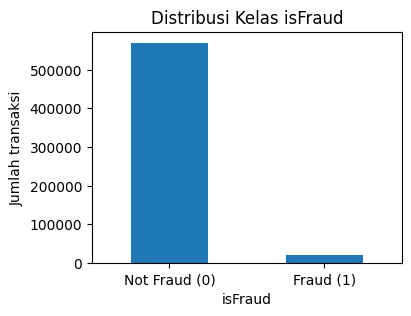

Proporsi fraud: 0.03499000914417313


In [4]:
# 2a. Visualisasi class imbalance isFraud
import matplotlib.pyplot as plt

fraud_counts = y.value_counts().sort_index()

plt.figure(figsize=(4,3))
fraud_counts.plot(kind="bar")
plt.xticks([0, 1], ["Not Fraud (0)", "Fraud (1)"], rotation=0)
plt.ylabel("Jumlah transaksi")
plt.title("Distribusi Kelas isFraud")
plt.show()

print("Proporsi fraud:", fraud_counts[1] / fraud_counts.sum())


In [5]:
# 3. TRAIN/VAL SPLIT
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [6]:
# 4. PREPROCESSOR
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer   # <- TAMBAHKAN INI

num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Untuk fitur numerik: isi NaN dengan median, lalu scaling
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Untuk fitur kategorik: isi NaN dengan kategori paling sering, lalu one-hot
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)


In [7]:
# 5a. MODEL 1: LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

log_reg = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(
            max_iter=200,
            class_weight="balanced",
            n_jobs=-1
        ))
    ]
)

log_reg.fit(X_train, y_train)

y_val_proba_lr = log_reg.predict_proba(X_val)[:, 1]
y_val_pred_lr  = (y_val_proba_lr >= 0.5).astype(int)

print("AUC LR:", roc_auc_score(y_val, y_val_proba_lr))
print(classification_report(y_val, y_val_pred_lr))



AUC LR: 0.7384329075353511
              precision    recall  f1-score   support

           0       0.98      0.75      0.85    113975
           1       0.08      0.61      0.14      4133

    accuracy                           0.75    118108
   macro avg       0.53      0.68      0.50    118108
weighted avg       0.95      0.75      0.83    118108



In [8]:
# 5b. MODEL 2: RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=200,
            max_depth=12,
            class_weight="balanced",
            n_jobs=-1,
            random_state=42
        ))
    ]
)

rf_clf.fit(X_train, y_train)

y_val_proba_rf = rf_clf.predict_proba(X_val)[:, 1]
y_val_pred_rf  = (y_val_proba_rf >= 0.5).astype(int)

print("AUC RF:", roc_auc_score(y_val, y_val_proba_rf))
print(classification_report(y_val, y_val_pred_rf))

AUC RF: 0.8377158535505158
              precision    recall  f1-score   support

           0       0.99      0.85      0.91    113975
           1       0.14      0.67      0.23      4133

    accuracy                           0.84    118108
   macro avg       0.56      0.76      0.57    118108
weighted avg       0.96      0.84      0.89    118108



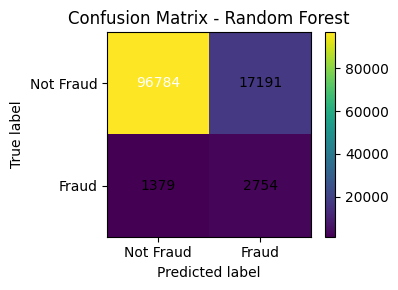

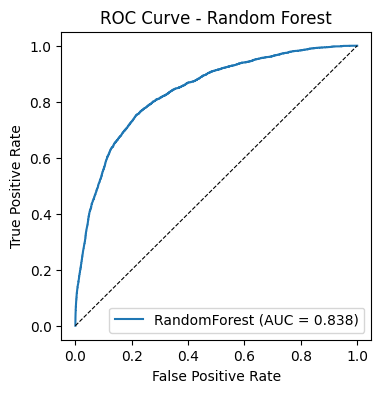

In [9]:
# 5b-visual. Confusion Matrix + ROC Random Forest
from sklearn.metrics import confusion_matrix, roc_curve, auc

cm = confusion_matrix(y_val, y_val_pred_rf)

plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix - Random Forest")
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ["Not Fraud", "Fraud"])
plt.yticks(tick_marks, ["Not Fraud", "Fraud"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max()/2 else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_proba_rf)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(4,4))
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC = {auc_rf:.3f})")
plt.plot([0,1], [0,1], "k--", linewidth=0.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


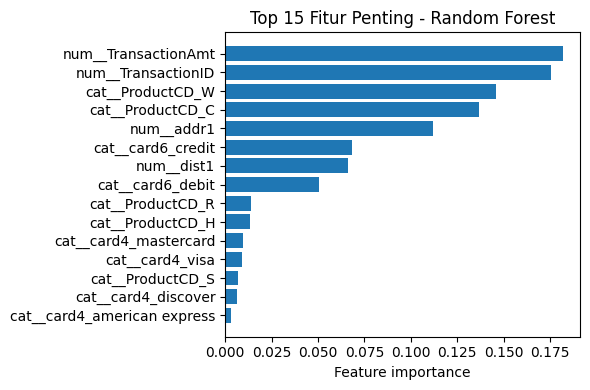

In [10]:
# 5b-feature. Feature importance Random Forest
pre = rf_clf.named_steps["preprocess"]
rf_model = rf_clf.named_steps["model"]

feature_names = pre.get_feature_names_out()
importances = rf_model.feature_importances_

idx = np.argsort(importances)[::-1][:15]   # 15 fitur teratas
top_features = feature_names[idx]
top_importances = importances[idx]

plt.figure(figsize=(6,4))
plt.barh(range(len(top_features)), top_importances[::-1])
plt.yticks(range(len(top_features)), top_features[::-1])
plt.xlabel("Feature importance")
plt.title("Top 15 Fitur Penting - Random Forest")
plt.tight_layout()
plt.show()


In [11]:
# 6. PREDIKSI UNTUK test_transaction.csv
test_path = "/content/drive/MyDrive/UTS ML & DL/Fraud Transaction/test_transaction.csv"
test_df = pd.read_csv(test_path)

X_test = test_df[selected_cols]   # sama seperti X_train tadi

y_test_proba = rf_clf.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    "TransactionID": test_df["TransactionID"],
    "isFraud": y_test_proba
})

submission.head()
submission.to_csv("submission_fraud_baseline.csv", index=False)
